In [36]:
! pip install pandas numpy matplotlib seaborn scikit-learn scipy


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

import os
from scipy.sparse import coo_matrix

# Step 1: Data Loading and Preprocessing

In [38]:
# Read your dataset (replace 'marketing_sample_for_walmart_com-walmart_com_product_review__20200701_20201231__5k_data.tsv' with your dataset path)
train_data = pd.read_csv('/kaggle/input/product/product_images_100000.csv', sep=',')
train_data.columns

Index(['Uniq Id', 'Crawl Timestamp', 'Dataset Origin', 'Product Id',
       'Product Barcode', 'Product Company Type Source',
       'Product Brand Source', 'Product Brand Normalised Source',
       'Product Name Source', 'Match Rank', 'Match Score', 'Match Type',
       'Retailer', 'Product Category', 'Product Brand', 'Product Name',
       'Product Price', 'Sku', 'Upc', 'Product Url', 'Market',
       'Product Description', 'Product Currency',
       'Product Available Inventory', 'Product Image Url',
       'Product Model Number', 'Product Tags', 'Product Rating',
       'Product Reviews Count', 'Bsr', 'Joining Key'],
      dtype='object')

In [39]:
train_data = train_data[['Uniq Id','Product Id', 'Product Rating', 'Product Reviews Count', 'Product Category', 'Product Brand', 'Product Name', 'Product Image Url', 'Product Description', 'Product Tags']]
train_data.head(3)

,Uniq Id,Product Id,Product Rating,Product Reviews Count,Product Category,Product Brand,Product Name,Product Image Url,Product Description,Product Tags
0,cbc44f16-6f74-4c8f-ba4b-7b2f216bea11,P00001,3.9,2524,Shoes,Lenovo,Lenovo Headphones Model-716,https://source.unsplash.com/300x300/?shoes&sig=1,Lenovo Headphones Model-716 is a high-quality ...,"Shoes, Lenovo, Electronics, Croma"
1,9a1accdb-35fd-4644-808b-f434de418d68,P00002,4.7,766,Laptop,HP,HP Speaker Model-648,https://source.unsplash.com/300x300/?laptop&sig=2,HP Speaker Model-648 is a high-quality Laptop ...,"Laptop, HP, Electronics, Myntra"
2,ecfe2477-afa4-4bca-bf72-b4b3cd36c269,P00003,3.0,2295,Tablet,Dell,Dell Shoes Model-303,https://source.unsplash.com/300x300/?tablet&sig=3,Dell Shoes Model-303 is a high-quality Tablet ...,"Tablet, Dell, Electronics, Croma"


In [40]:
print(train_data.columns.tolist())


['Uniq Id', 'Product Id', 'Product Rating', 'Product Reviews Count', 'Product Category', 'Product Brand', 'Product Name', 'Product Image Url', 'Product Description', 'Product Tags']


In [41]:
import pandas as pd
import os

train_data = pd.read_csv('/kaggle/input/product/product_images_100000.csv')  # Update with your actual CSV file path
train_data.columns = train_data.columns.str.strip()  # Strip any extra spaces

# Filter correct columns based on your dataset
filtered_data = train_data[['Product Name', 'Product Reviews Count', 'Product Brand', 'Product Rating', 'Product Image Url']]

# Create 'data' folder if it doesn't exist
os.makedirs("data", exist_ok=True)

# Save filtered data
filtered_data.to_csv("data/filtered_data.csv", index=False)


In [42]:
train_data['Product Tags']

0                    Shoes, Lenovo, Electronics, Croma
1                      Laptop, HP, Electronics, Myntra
2                     Tablet, Dell, Electronics, Croma
3          Laptop, Sony, Electronics, Reliance Digital
4        Watch, Samsung, Electronics, Reliance Digital
                             ...                      
99995                   Bag, Asus, Electronics, Myntra
99996              Speaker, Canon, Electronics, Myntra
99997      Camera, Asus, Electronics, Reliance Digital
99998    Laptop, Adidas, Electronics, Reliance Digital
99999                  Bag, Lenovo, Electronics, Croma
Name: Product Tags, Length: 100000, dtype: object

In [43]:
train_data.shape

(100000, 31)

In [44]:
train_data.isnull().sum()

Uniq Id                            0
Crawl Timestamp                    0
Dataset Origin                     0
Product Id                         0
Product Barcode                    0
Product Company Type Source        0
Product Brand Source               0
Product Brand Normalised Source    0
Product Name Source                0
Match Rank                         0
Match Score                        0
Match Type                         0
Retailer                           0
Product Category                   0
Product Brand                      0
Product Name                       0
Product Price                      0
Sku                                0
Upc                                0
Product Url                        0
Market                             0
Product Description                0
Product Currency                   0
Product Available Inventory        0
Product Image Url                  0
Product Model Number               0
Product Tags                       0
P

In [45]:
train_data.duplicated().sum()

0

In [46]:
# make columns shorter
# Define the mapping of current column names to shorter names
column_name_mapping = {
    'Uniq Id': 'ID',
    'Product Id': 'ProdID',
    'Product Rating': 'Rating',
    'Product Reviews Count': 'ReviewCount',
    'Product Category': 'Category',
    'Product Brand': 'Brand',
    'Product Name': 'Name',
    'Product Image Url': 'ImageURL',
    'Product Description': 'Description',
    'Product Tags': 'Tags',
    'Product Contents': 'Contents'
}
# Rename the columns using the mapping
train_data.rename(columns=column_name_mapping, inplace=True)

In [47]:
train_data['ID'] = train_data['ID'].str.extract(r'(\d+)').astype(float)
train_data['ProdID'] = train_data['ProdID'].str.extract(r'(\d+)').astype(float)

# Step 2: EDA (Exploratory Data Analysis)

In [48]:
# Basic statistics
num_users = train_data['ID'].nunique()
num_items = train_data['ProdID'].nunique()
num_ratings = train_data['Rating'].nunique()
print(f"Number of unique users: {num_users}")
print(f"Number of unique items: {num_items}")
print(f"Number of unique ratings: {num_ratings}")

Number of unique users: 20721
Number of unique items: 100000
Number of unique ratings: 21


In [49]:
print(train_data.columns.tolist())
train_data.columns = train_data.columns.str.strip()


['ID', 'Crawl Timestamp', 'Dataset Origin', 'ProdID', 'Product Barcode', 'Product Company Type Source', 'Product Brand Source', 'Product Brand Normalised Source', 'Product Name Source', 'Match Rank', 'Match Score', 'Match Type', 'Retailer', 'Category', 'Brand', 'Name', 'Product Price', 'Sku', 'Upc', 'Product Url', 'Market', 'Description', 'Product Currency', 'Product Available Inventory', 'ImageURL', 'Product Model Number', 'Tags', 'Rating', 'ReviewCount', 'Bsr', 'Joining Key']


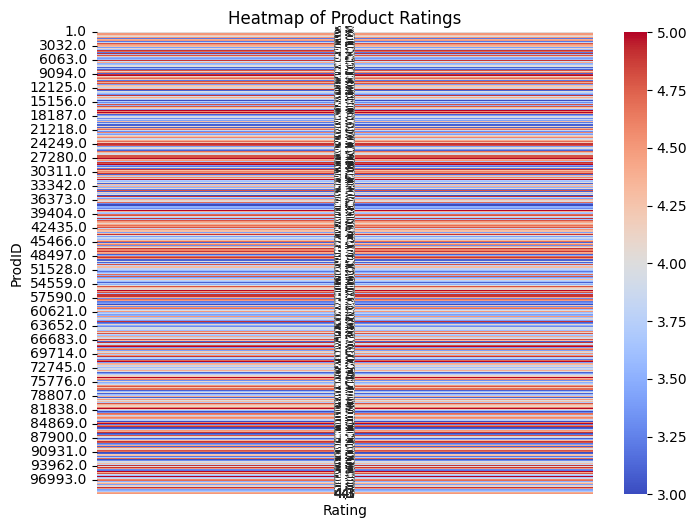

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# Creating pivot table
heatmap_data = train_data.pivot_table(values='Rating', index='ProdID', aggfunc='mean')

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt='g', cmap='coolwarm', cbar=True)
plt.title('Heatmap of Product Ratings')
plt.show()


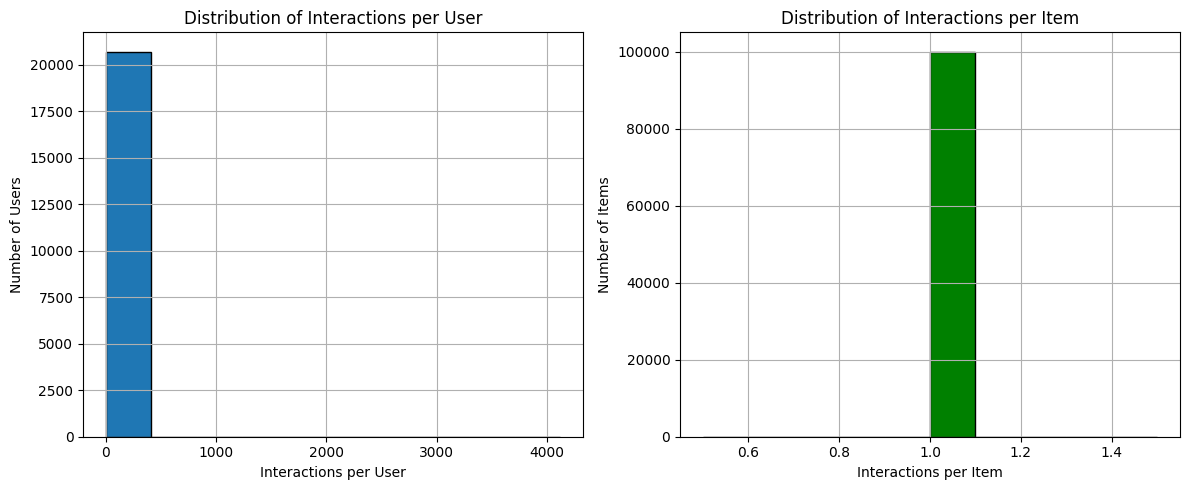

In [52]:
# Distribution of interactions
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
train_data['ID'].value_counts().hist(bins=10, edgecolor='k')
plt.xlabel('Interactions per User')
plt.ylabel('Number of Users')
plt.title('Distribution of Interactions per User')

plt.subplot(1, 2, 2)
train_data['ProdID'].value_counts().hist(bins=10, edgecolor='k',color='green')
plt.xlabel('Interactions per Item')
plt.ylabel('Number of Items')
plt.title('Distribution of Interactions per Item')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Most Popular items')

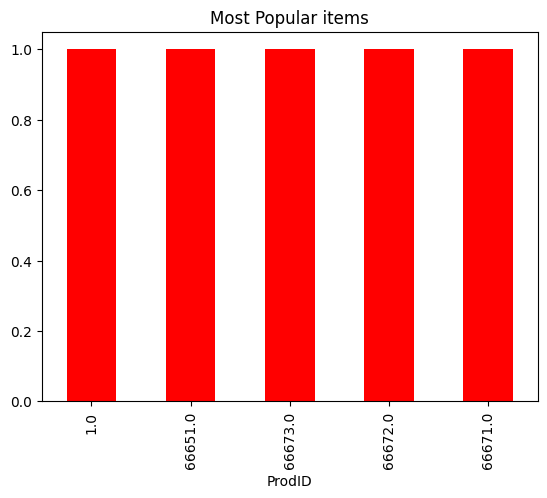

In [53]:
# Most popular items
popular_items = train_data['ProdID'].value_counts().head(5)
popular_items.plot(kind='bar',color='red')
plt.title("Most Popular items")

<Axes: xlabel='Rating'>

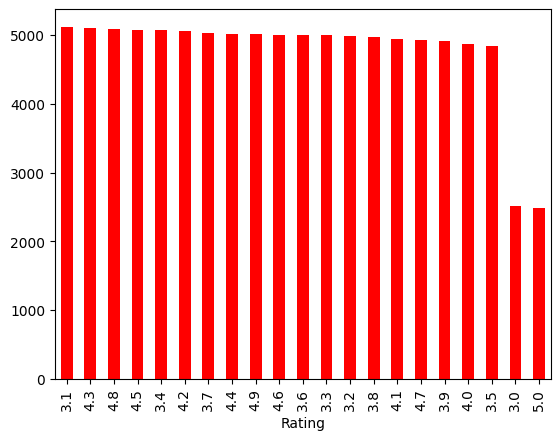

In [55]:
# most rated counts
train_data['Rating'].value_counts().plot(kind='bar',color='red')

# Step 3: Data Cleaning and Tags Creations

In [56]:
import pandas as pd
import spacy
from tqdm import tqdm

# Load spacy model
nlp = spacy.load("en_core_web_sm")

# Define function to clean and extract tags from a list of texts
def clean_and_extract_tags(texts):
    tags_list = []
    for doc in nlp.pipe(texts, disable=["ner", "parser"], batch_size=50):  # Disable unnecessary components for speed
        tags = [token.text for token in doc if token.is_alpha and not token.is_stop]
        tags_list.append(', '.join(tags))
    return tags_list

# Apply tqdm with progress bar on each column
columns_to_extract_tags_from = ['Category', 'Brand', 'Description']

for column in columns_to_extract_tags_from:
    print(f"Processing column: {column}")
    # Use the pipe method for batch processing
    train_data[column] = tqdm(clean_and_extract_tags(train_data[column].fillna('').tolist()), desc=f'Processing {column}')


Processing column: Category


Processing Category: 100%|██████████| 100000/100000 [00:00<00:00, 3826605.48it/s]


Processing column: Brand


Processing Brand: 100%|██████████| 100000/100000 [00:00<00:00, 4136557.66it/s]


Processing column: Description


Processing Description: 100%|██████████| 100000/100000 [00:00<00:00, 2563567.46it/s]


In [57]:
# Concatenate the cleaned tags from all relevant columns
train_data['Tags'] = train_data[columns_to_extract_tags_from].apply(lambda row: ', '.join(row), axis=1)

# Step 4: Rating Base Recommendations System

In [58]:
average_ratings = train_data.groupby(['Name','ReviewCount','Brand','ImageURL'])['Rating'].mean().reset_index()

In [59]:
top_rated_items = average_ratings.sort_values(by='Rating', ascending=False)

rating_base_recommendation = top_rated_items.head(10)

In [60]:
rating_base_recommendation['Rating'] = rating_base_recommendation['Rating'].astype(int)
rating_base_recommendation['ReviewCount'] = rating_base_recommendation['ReviewCount'].astype(int)

/tmp/ipykernel_31/565725879.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_base_recommendation['Rating'] = rating_base_recommendation['Rating'].astype(int)
/tmp/ipykernel_31/565725879.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_base_recommendation['ReviewCount'] = rating_base_recommendation['ReviewCount'].astype(int)


In [61]:
print("Rating Base Recommendation System: (Trending Products)")
rating_base_recommendation[['Name','Rating','ReviewCount','Brand','ImageURL']] = rating_base_recommendation[['Name','Rating','ReviewCount','Brand','ImageURL']]
rating_base_recommendation


Rating Base Recommendation System: (Trending Products)


/tmp/ipykernel_31/513219373.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_base_recommendation[['Name','Rating','ReviewCount','Brand','ImageURL']] = rating_base_recommendation[['Name','Rating','ReviewCount','Brand','ImageURL']]


,Name,ReviewCount,Brand,ImageURL,Rating
73704,Nike Laptop Model-947,4541,Nike,https://source.unsplash.com/300x300/?laptop&si...,5
47314,Dell Tablet Model-545,288,Dell,https://source.unsplash.com/300x300/?headphone...,5
82282,Samsung Headphones Model-330,2180,Samsung,https://source.unsplash.com/300x300/?headphone...,5
58852,HP Watch Model-143,4361,HP,https://source.unsplash.com/300x300/?tablet&si...,5
47297,Dell Tablet Model-532,1740,Dell,https://source.unsplash.com/300x300/?televisio...,5
33541,Canon Laptop Model-437,2262,Canon,https://source.unsplash.com/300x300/?tablet&si...,5
86077,Samsung Speaker Model-222,4683,Samsung,https://source.unsplash.com/300x300/?tablet&si...,5
67061,Lenovo Tablet Model-252,2384,Lenovo,https://source.unsplash.com/300x300/?mobile&si...,5
67050,Lenovo Tablet Model-246,1801,Lenovo,https://source.unsplash.com/300x300/?shoes&sig...,5
33583,Canon Laptop Model-492,3368,Canon,https://source.unsplash.com/300x300/?tablet&si...,5


# Step 5 Content Base Recommendation system (User Preferences or Items similarities)

In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Select the text-based column (e.g., 'Description' or 'Tags')
text_data = train_data['Description'].fillna('')  # Replace NaN values with empty strings

# Create TF-IDF matrix
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix_content = tfidf_vectorizer.fit_transform(text_data)

print(tfidf_matrix_content.shape)  # Check matrix dimensions
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=10)
nn.fit(tfidf_matrix_content)
distances, indices = nn.kneighbors(tfidf_matrix_content)


(100000, 23)


In [64]:
item_name = 'Lenovo Headphones Model-716'

# Find the index of the item in the train_data
item_index = train_data[train_data['Name'] == item_name].index[0]

# Get the nearest neighbors for that item
recommended_indices = indices[item_index][1:]  # Exclude the item itself if needed
recommended_distances = distances[item_index][1:]

# Fetch the recommended product details
recommended_items = train_data.iloc[recommended_indices][['Name', 'ReviewCount', 'Brand', 'ImageURL', 'Rating']]


# Function To Recommend Products for Content Base

In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
import pandas as pd

# Generate recommendations (assuming 'Name' is the product name column)
def content_based_recommendations(train_data, product_name, top_n=5):
    index = train_data[train_data['Name'] == product_name].index[0]  # Change 'Product Name' to 'Name'
    distances, indices = nn.kneighbors(tfidf_matrix_content[index])
    return train_data.iloc[indices[0][1:top_n+1]]['Name']  # Change 'Product Name' to 'Name'


    tfidf_vectorizer = TfidfVectorizer(stop_words='english')
    train_data['combined_features'] = (
        train_data['Product Name'].fillna('') + ' ' + train_data['Product Brand'].fillna('')
    )

    tfidf_matrix = tfidf_vectorizer.fit_transform(train_data['combined_features'])
    item_index = train_data[train_data['Product Name'] == item_name].index[0]
    cosine_sim = linear_kernel(tfidf_matrix[item_index], tfidf_matrix).flatten()
    sim_scores = list(enumerate(cosine_sim))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    top_similar_items = sim_scores[1:top_n+1]
    indices = [i[0] for i in top_similar_items]

    recommendations = train_data.iloc[indices][['Product Name', 'ReviewCount', 'Product Brand', 'ImageURL', 'Rating']]
    return recommendations

# Example usage
recommendations = content_based_recommendations(train_data, "Lenovo Headphones Model-716", top_n=5)
print(recommendations)


89537    Lenovo Headphones Model-437
91049    Lenovo Headphones Model-149
7890     Lenovo Headphones Model-830
83689         Lenovo Shoes Model-656
82467    Lenovo Headphones Model-866
Name: Name, dtype: object


In [66]:
# Example: Get content-based recommendations for a specific item
item_name = 'Lenovo Headphones Model-716'
content_based_rec = content_based_recommendations(train_data, item_name, top_n=8)

content_based_rec

89537    Lenovo Headphones Model-437
91049    Lenovo Headphones Model-149
7890     Lenovo Headphones Model-830
83689         Lenovo Shoes Model-656
82467    Lenovo Headphones Model-866
78736    Lenovo Headphones Model-858
3940     Lenovo Headphones Model-575
2527          Lenovo Shoes Model-316
Name: Name, dtype: object

# Step 6  Collaborative Filtering (Item-Based Collaborative Filtering using K-Nearest Neighbors (KNN) with a sparse matrix)

In [67]:
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# Use 'ProdID' as the product identifier and 'Rating' as the rating
# If you have user-level data, add it here as 'UserID'

# Encode products
train_data['item_idx'] = train_data['ProdID'].astype("category").cat.codes

# Create a mapping for item index to product details
item_id_mapping = train_data.drop_duplicates('item_idx').set_index('item_idx')[['ProdID', 'Name']].to_dict('index')

# If you do NOT have user-level data, you cannot build a user-item matrix.
# Instead, you can use only product features or aggregate ratings.

# Example: Build a dummy user column if you want to proceed with collaborative filtering (not ideal)
train_data['user_idx'] = 0  # All ratings are from a single dummy user

# Build sparse matrix (Item-User)
sparse_item_user_matrix = csr_matrix(
    (train_data['Rating'], (train_data['item_idx'], train_data['user_idx']))
)

# Fit Item-Item KNN model
item_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=6)
item_knn.fit(sparse_item_user_matrix)

# Example - Find similar items for a particular product
target_product_id = 1  # Example ProdID

if target_product_id in train_data['ProdID'].values:
    target_item_idx = train_data.loc[train_data['ProdID'] == target_product_id, 'item_idx'].iloc[0]
    distances, indices = item_knn.kneighbors(sparse_item_user_matrix[target_item_idx], n_neighbors=6)

    print(f"Top similar items for ProdID: {target_product_id}")
    print("--------------------------------------------------")
    print("Rank\tItem Index\tProdID\tName\t\tSimilarity Score")
    print("--------------------------------------------------")
    for i in range(1, len(indices.flatten())):  # Exclude the target item itself
        similar_item_idx = indices.flatten()[i]
        similarity_score = 1 - distances.flatten()[i]
        item_info = item_id_mapping.get(similar_item_idx)
        if item_info:
            print(f"{i}\t\t{similar_item_idx}\t\t{item_info['ProdID']}\t\t{item_info['Name']}\t\t{similarity_score:.4f}")
        else:
            print(f"{i}\t\t{similar_item_idx}\t\tProdID not found")
else:
    print(f"ProdID '{target_product_id}' not found in the training data.")


Top similar items for ProdID: 1
--------------------------------------------------
Rank	Item Index	ProdID	Name		Similarity Score
--------------------------------------------------
1		66669		66670.0		Apple Mobile Model-515		1.0000
2		66665		66666.0		Sony Laptop Model-866		1.0000
3		66666		66667.0		Dell Tablet Model-383		1.0000
4		66667		66668.0		Canon Tablet Model-439		1.0000
5		66663		66664.0		Samsung Television Model-679		1.0000


# Item-based collaborative filtering

In [72]:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# Step 1: Encode users and products
train_data['user_idx'] = train_data['ID'].astype("category").cat.codes
train_data['item_idx'] = train_data['ProdID'].astype("category").cat.codes

# Step 2: Build sparse matrix (Item-User)
sparse_item_user_matrix = csr_matrix(
    (train_data['Rating'], (train_data['item_idx'], train_data['user_idx']))
)

# Step 3: Fit Item-Item KNN model
item_knn = NearestNeighbors(metric='cosine', algorithm='brute')
item_knn.fit(sparse_item_user_matrix)

# Step 4: Example - Find similar items for a particular product
target_item_idx = 100  # Example item index
distances, indices = item_knn.kneighbors(sparse_item_user_matrix[target_item_idx], n_neighbors=6)

# Step 5: Print similar item indices
print("Top similar items (item indices):", indices.flatten()[1:])
print("Similarity scores (lower is better):", distances.flatten()[1:])

# Create a dictionary mapping indices to (index, Product ID, Name)
item_mapping = {i: (i, train_data.iloc[i]['ProdID'], train_data.iloc[i]['Name']) for i in range(len(train_data))}

for idx in indices.flatten()[1:]:
    item_info = item_mapping.get(idx, None)
    if item_info is not None:
        print(f"Item Index: {idx}, Product ID: {item_info[1]}, Name: {item_info[2]}")
    else:
        print(f"Item Index: {idx} - Not Found in Mapping")

# If you want to recommend for a specific user ID (e.g., ID = 4)
target_user_id = 4

# Get encoded index of that user (mapped using category encoding earlier)
target_user_index = train_data.loc[train_data['ID'] == target_user_id, 'user_idx'].values[0]

print("Encoded User Index for User ID 4:", target_user_index)


Top similar items (item indices): [41527 26062 50797 62744 80868]
Similarity scores (lower is better): [0. 0. 0. 0. 0.]
Item Index: 41527, Product ID: 41528.0, Name: Dell Watch Model-221
Item Index: 26062, Product ID: 26063.0, Name: Apple Headphones Model-130
Item Index: 50797, Product ID: 50798.0, Name: Sony Tablet Model-944
Item Index: 62744, Product ID: 62745.0, Name: Dell Speaker Model-559
Item Index: 80868, Product ID: 80869.0, Name: Asus Bag Model-866
Encoded User Index for User ID 4: 4


# user-based collaborative filtering

In [ ]:
import pandas as pd
from scipy.sparse import coo_matrix
from sklearn.neighbors import NearestNeighbors


#  Rename columns if necessary
train_data = train_data.rename(columns={'ID': 'UserID', 'ProdID': 'ProductID', 'Rating': 'ProductRating'})

# Handle missing values in 'ProductRating'
train_data['ProductRating'] = pd.to_numeric(train_data['ProductRating'], errors='coerce').fillna(0)

# Reduce memory usage by downcasting numeric columns
train_data['UserID'] = train_data['UserID'].astype('int32')
train_data['ProductID'] = train_data['ProductID'].astype('int32')
train_data['ProductRating'] = train_data['ProductRating'].astype('float32')

#  Convert to sparse matrix (efficient way)
rows = train_data['UserID'].astype('category').cat.codes
cols = train_data['ProductID'].astype('category').cat.codes
values = train_data['ProductRating']

sparse_user_item_matrix = coo_matrix((values, (rows, cols)))

# Train KNN Model
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=6)
model_knn.fit(sparse_user_item_matrix)

# Find similar users for a given user index
target_user_index = 0  # Make sure this is a valid index
distances, indices = model_knn.kneighbors(sparse_user_item_matrix.getrow(target_user_index), n_neighbors=6)

# Display similar users
print("Top similar users:", indices.flatten()[1:])  # Exclude self (index 0)




from scipy.sparse import csr_matrix

# Convert coo_matrix to csr_matrix (supports indexing)
sparse_user_item_matrix = sparse_user_item_matrix.tocsr()

# Find similar users
distances, indices = model_knn.kneighbors(sparse_user_item_matrix[target_user_index], n_neighbors=6)

# Print similar users
print("Top similar users (user indices):", indices.flatten()[1:])
print("Similarity scores (lower is better):", distances.flatten()[1:])

# Let's get all items rated by similar users
similar_user_indices = indices.flatten()[1:]  # excluding the user itself

# Get items rated by these similar users
recommended_items = train_data[train_data['user_idx'].isin(similar_user_indices)]

# Optionally, filter top-rated items
top_rated_items = recommended_items[recommended_items['ProductRating'] >= 4]


# Drop duplicates to avoid repeated items
top_items = top_rated_items[['ProductID', 'Name']].drop_duplicates()


print("\nRecommended Products for User ID 4:")
print(top_items)

# Assign to a variable named 'recommended_items_details'
recommended_items_details = top_items

# Display top 10 recommendations
print(recommended_items_details.head(10))


recommended_items_details.head(10)


Columns in dataset: Index(['ID', 'Crawl Timestamp', 'Dataset Origin', 'ProdID', 'Product Barcode',
       'Product Company Type Source', 'Product Brand Source',
       'Product Brand Normalised Source', 'Product Name Source', 'Match Rank',
       'Match Score', 'Match Type', 'Retailer', 'Category', 'Brand', 'Name',
       'Product Price', 'Sku', 'Upc', 'Product Url', 'Market', 'Description',
       'Product Currency', 'Product Available Inventory', 'ImageURL',
       'Product Model Number', 'Tags', 'Rating', 'ReviewCount', 'Bsr',
       'Joining Key', 'item_idx', 'user_idx'],
      dtype='object')
Top similar users: [13818 13815 13816 13813 13817]
Top similar users (user indices): [13818 13815 13816 13813 13817]
Similarity scores (lower is better): [1. 1. 1. 1. 1.]

Recommended Products for User ID 4:
       ProductID                       Name
15658      15659  Dell Headphones Model-620
       ProductID                       Name
15658      15659  Dell Headphones Model-620


,ProductID,Name
15658,15659,Dell Headphones Model-620


# Step 7  Hybrid Recommendations

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

# STEP 1: Prepare Encoded Features for Content-Based Filtering
def prepare_item_features(train_data):
    # Ensure correct column names
    expected_columns = ['ProductID', 'Name', 'Brand', 'Category', 'ProductRating', 'ReviewCount']
    missing_columns = [col for col in expected_columns if col not in train_data.columns]
    
    if missing_columns:
        raise KeyError(f"Missing columns in dataset: {missing_columns}")

    item_features = train_data.drop_duplicates(subset='ProductID')[expected_columns].copy()

    # Encoding categorical features
    le_brand = LabelEncoder()
    le_category = LabelEncoder()
    item_features['Brand_enc'] = le_brand.fit_transform(item_features['Brand'].astype(str))
    item_features['Category_enc'] = le_category.fit_transform(item_features['Category'].astype(str))

    # Selecting only required numeric columns
    item_features_encoded = item_features[['Brand_enc', 'Category_enc', 'ProductRating', 'ReviewCount']]

    return item_features, item_features_encoded


# STEP 2: Content-based Recommendation using Nearest Neighbors
def get_similar_items_nn(item_features_encoded, item_features, item_name, n_similar=10):
    model = NearestNeighbors(metric='cosine', algorithm='brute')
    model.fit(item_features_encoded)

    item_idx = item_features[item_features['Name'] == item_name].index[0]
    distances, indices = model.kneighbors([item_features_encoded.iloc[item_idx]], n_neighbors=n_similar+1)

    similar_indices = indices.flatten()[1:]  # Exclude the item itself
    return item_features.iloc[similar_indices][['Name', 'Brand', 'ProductRating', 'ReviewCount']]


# STEP 3: Collaborative Filtering (Fixed)
def collaborative_filtering_recommendations_sparse(train_data, target_user_id, top_n=10):
   
    train_data['user_idx'] = train_data['UserID'].astype('category').cat.codes
    train_data['item_idx'] = train_data['ProductID'].astype('category').cat.codes

    user_id_map = dict(enumerate(train_data.drop_duplicates('user_idx')[['user_idx', 'UserID']].values))
    item_id_map = dict(enumerate(train_data.drop_duplicates('item_idx')[['item_idx', 'ProductID', 'Name', 'Brand', 'ProductRating', 'ReviewCount']].values))

    sparse_matrix = csr_matrix((train_data['ProductRating'], (train_data['user_idx'], train_data['item_idx'])))

    model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
    model_knn.fit(sparse_matrix)

    target_user_idx = train_data[train_data['UserID'] == target_user_id]['user_idx'].values[0]
    distances, indices = model_knn.kneighbors(sparse_matrix[target_user_idx], n_neighbors=6)

    similar_user_indices = indices.flatten()[1:]
    recommended_items = train_data[train_data['user_idx'].isin(similar_user_indices)]
    top_rated = recommended_items[recommended_items['ProductRating'] >= 4]

    user_items = train_data[train_data['user_idx'] == target_user_idx]['item_idx'].tolist()
    top_rated = top_rated[~top_rated['item_idx'].isin(user_items)]

    top_items = top_rated[['item_idx']].drop_duplicates().head(top_n)

    recommended_items_details = []
    for idx in top_items['item_idx']:
        details = item_id_map.get(idx, None)
        if details is not None:
            recommended_items_details.append(details)

    columns = ['item_idx', 'ProductID', 'Name', 'Brand', 'ProductRating', 'ReviewCount']
    return pd.DataFrame(recommended_items_details, columns=columns).drop(columns='item_idx')


# STEP 4: Hybrid Recommendation Function
def hybrid_recommendations(train_data, target_user_id, item_name, top_n=10):
    item_features, item_features_encoded = prepare_item_features(train_data)

    content_rec = get_similar_items_nn(item_features_encoded, item_features, item_name, n_similar=top_n)
    collaborative_rec = collaborative_filtering_recommendations_sparse(train_data, target_user_id, top_n=top_n)

    hybrid_df = pd.concat([content_rec, collaborative_rec]).drop_duplicates(subset=['Name']).head(top_n)
    return hybrid_df

# Usage
target_user_id = 10
item_name = 'Adidas Watch Model-885'
hybrid_rec = hybrid_recommendations(train_data, target_user_id, item_name, top_n=10)
print(hybrid_rec)


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


                           Name   Brand  ProductRating  ReviewCount  ProductID
69       Adidas Watch Model-885  Adidas            4.4         3565        NaN
90005      Adidas Bag Model-246  Adidas            4.5         3541        NaN
266        Adidas Bag Model-790  Adidas            4.0         3184        NaN
55740   Adidas Mobile Model-198  Adidas            3.9         3242        NaN
49518   Adidas Laptop Model-176  Adidas            4.1         3250        NaN
42198    Adidas Shoes Model-410  Adidas            4.6         3616        NaN
94842   Adidas Camera Model-160  Adidas            4.1         3203        NaN
40035   Adidas Laptop Model-695  Adidas            4.1         3269        NaN
44307   Adidas Tablet Model-945  Adidas            4.3         3489        NaN
6053   Adidas Speaker Model-334  Adidas            4.6         3879        NaN


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
